# **Time Series Forecasting**
![](https://www.entrepreneurshipinabox.com/wp-content/uploads/demand-and-sales-forecasting.jpg.webp)

<a class="anchor" id="0.1"></a>
# **Table of Contents**
1.	[Business Objective and Context](#1)
2.	[EDA](#2)
5.	[Building the Arima Model and Evaluation](#3)
6.	[Building the prophet Model and Evaluation](#4)
7.	[Future Model Improvements and Business Scenario](#5)


# **1. Business Objective and Context** <a class="anchor" id="1"></a>
In this modern times where every business is highly dependent on its data to make better decisions for developing business, time series analysis plays an important role in helping different business entities to get an idea about how good their sales are by implementing sales forecating on the historic data. 
We have ultisied the dataset to perform expolratory data analysis to gain valuable insights and further apply time series analysis to get a forecast of sales 

This notebooks aims to,
1.  Analyze time series data.
2.  Forecast (predict) future values for the same.

In order to achieve the above goals two important and efficient moudules are used,
1.  ARIMA
2.  Prophet


# 2. Exploring DATA  <a class="anchor" id="2"></a>


In [161]:
#
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'#for creating iteartion for effective looping 
import statsmodels.api as sm #statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, 
#from mlxtend.frequent_patterns import apriori, association_rules
import pyodbc
import pygrametl

In [162]:
#Connect to the Staging Area
myconn = pyodbc.connect(r'Driver=SQL Server;Server=LAPTOP-JVHJP0A7;Database=SA_SALES;Trusted_Connection=yes;')
cursor = myconn.cursor()
connection = pygrametl.ConnectionWrapper(myconn)

connection.setasdefault()

In [163]:
order = pd.read_sql_query("select * from dbo.ORDERS", con=myconn)
order.head()

,RowIDS,ORDERIDS,OrderDateS,ShipDateS,ShipModeS,Customer_IDS,CustomerNameS,SegmentS,CityS,StateS,...,CategoryS,Sub-CategoryS,Product NameS,Quantity,Discount,Profit,Shipping Cost,OrderPriority,PostalCodeS,Sales
0,27932,IN-2012-FW1439511-41196,2012-10-14,2012-10-19,Standard Class,FW-1439511,Fred Wasserman,Corporate,Dhaka,Dhaka,...,Technology,Copiers,"Hewlett Fax Machine, Digital",3.0,0.0,373.8600,80.93,Medium,None,958.680
1,33738,CA-2014-AF10870140-41782,2014-05-23,2014-05-28,Standard Class,AF-108701406,Art Ferguson,Consumer,Passaic,New Jersey,...,Furniture,Tables,Bevis 36 x 72 Conference Tables,2.0,0.3,-19.9184,8.91,Medium,None,174.286
2,39497,CA-2015-AF10870140-42119,2015-04-25,2015-05-01,Standard Class,AF-108701402,Art Ferguson,Consumer,Chicago,Illinois,...,Office Supplies,Storage,Safco Industrial Wire Shelving System,1.0,0.2,-18.1960,5.88,Medium,None,72.784
3,47536,MO-2015-MC759086-42033,2015-01-29,2015-02-01,Second Class,MC-759086,Matt Collister,Corporate,Rabat,Rabat-Salé-Zemmour-Zaer,...,Technology,Accessories,"Memorex Memory Card, Programmable",4.0,0.0,58.0800,80.80,Critical,None,415.080
4,40965,CA-2014-AF10870140-41753,2014-04-24,2014-04-28,Standard Class,AF-108701404,Art Ferguson,Consumer,San Clemente,California,...,Office Supplies,Envelopes,Recycled Interoffice Envelopes with String and...,3.0,0.0,35.9850,5.86,Medium,None,71.970


**<h3>Let's find out who are the Most Valuable customers!</h3>**

The Most Valuable Customers are the customers who are the most profitable for a company. <br>
These customers buy more or higher-value products than the average customer.

In [164]:
Top_customers = order.groupby(["CustomerNameS"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the Customers as per the sales
Top_customers = Top_customers[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_customers.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the customer name into dataframe 

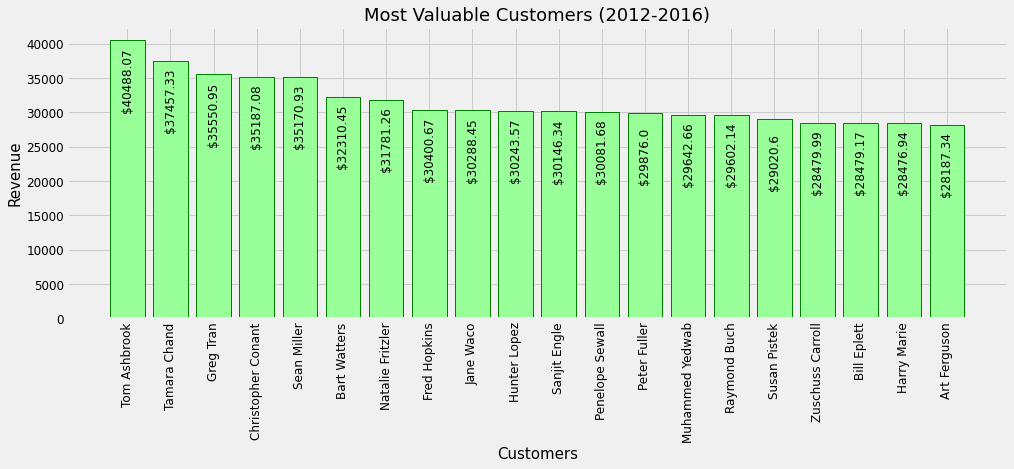

In [165]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Most Valuable Customers (2012-2016)", fontsize=18) 
plt.bar(Top_customers["CustomerNameS"], Top_customers["Sales"],color= '#99ff99',edgecolor='green', linewidth = 1)
plt.xlabel("Customers",fontsize=15) # x axis shows the customers 
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_customers["Sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-10000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [166]:
Top_customers = order.groupby(["CountryS"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the Customers as per the sales
Top_customers = Top_customers[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_customers.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the customer name into dataframe 

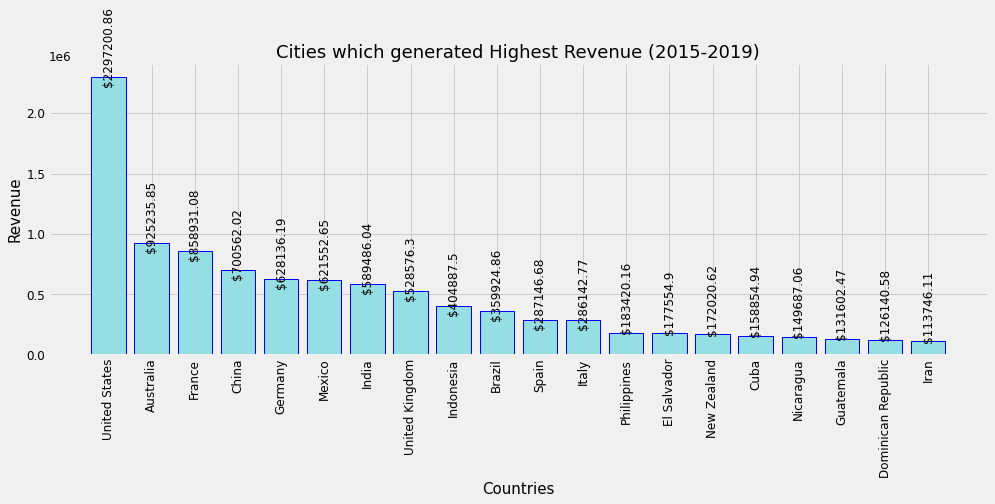

In [167]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Cities which generated Highest Revenue (2015-2019)", fontsize=18)
plt.bar(Top_customers["CountryS"], Top_customers["Sales"],color= '#95DEE3',edgecolor='blue', linewidth = 1)
plt.xlabel("Countries",fontsize=15)  # x axis shows the States
plt.ylabel("Revenue",fontsize=15)  # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_customers["Sales"].items(): #To show the exact revenue generated on the figure
    if v>250000:
        plt.text(k,v-55000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [168]:
Top_category = order.groupby(["CategoryS"]).sum().sort_values("Sales", ascending=False)  # Sort the Categories as per the sales
Top_category = Top_category[["Sales"]] # keep only the sales column in the dataframe
total_revenue_category = Top_category["Sales"].sum() # To find the total revenue generated as per category
total_revenue_category = str(int(total_revenue_category)) # Convert the total_revenue_category from float to int and then to string
total_revenue_category = '$' + total_revenue_category # Adding '$' sign before the Value
Top_category.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the category into the dataframe

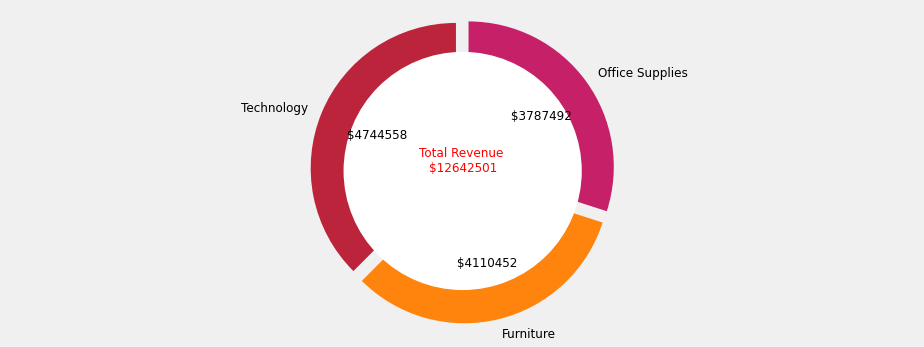

In [169]:
plt.rcParams["figure.figsize"] = (13,5) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined
plt.rcParams['font.weight'] = 6 # Font weight is defined
# we don't want to look at the percentage distribution in the pie chart. Instead, we want to look at the exact revenue generated by the categories.
def autopct_format(values): 
    def my_format(pct): 
        total = sum(values) 
        val = int(round(pct*total/100.0))
        return ' ${v:d}'.format(v=val)
    return my_format
colors = ['#BC243C','#FE840E','#C62168'] # Colors are defined for the pie chart
explode = (0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_category['Sales'], colors = colors, labels=Top_category['CategoryS'], autopct= autopct_format(Top_category['Sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.82,fc='white') # drawing a circle on the pie chart to make it look better 
fig = plt.gcf()
fig.gca().add_artist(centre_circle) # Add the circle on the pie chart
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
# we can look the total revenue generated by all the categories at the center
label = ax1.annotate('Total Revenue \n'+str(total_revenue_category),color = 'red', xy=(0, 0), fontsize=12, ha="center")
plt.tight_layout()
plt.show()

**<h3> Which products contributed most to the revenue? </h3>**

In [170]:
Top_products = order.groupby(["Product NameS"]).sum().sort_values("Sales",ascending=False).head(8) # Sort the product names as per the sales
Top_products = Top_products[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_products.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the product names into the dataframe
total_revenue_products = Top_products["Sales"].sum() # To find the total revenue generated by all the top products
total_revenue_products = str(int(total_revenue_products)) # Convert the total_revenue_products from float to int and then to string
total_revenue_products = '$' + total_revenue_products # Adding '$' sign before the Value

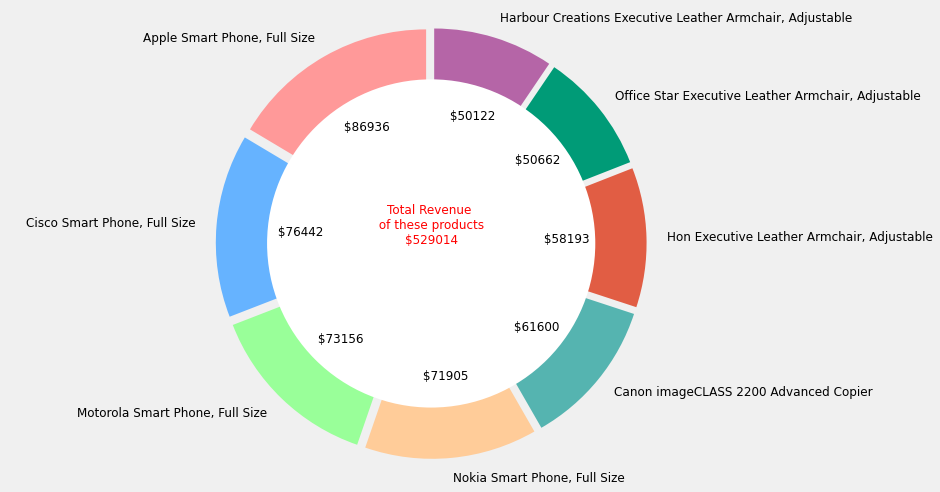

In [171]:
plt.rcParams["figure.figsize"] = (13,7) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined for the figure
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#55B4B0','#E15D44','#009B77','#B565A7'] # colors are defined for the pie chart
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_products['Sales'], colors = colors, labels=Top_products['Product NameS'], autopct= autopct_format(Top_products['Sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.80,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
label = ax1.annotate('Total Revenue \n of these products \n'+str(total_revenue_products),color = 'red', xy=(0, 0), fontsize=12, ha="center")
plt.tight_layout()
plt.show()

We can see that Product - Apple Smart Phone , Full Size generated the highest revenue of about $61600!

The Total Revenue generated by all these products - $209624!

In [172]:
# Sort both category and  sub category as per the sales
Top_subcat = order.groupby(['CategoryS','Sub-CategoryS']).sum().sort_values("Sales", ascending=False).head(10)
Top_subcat = Top_subcat[["Sales"]].astype(int) # Cast Sales column to integer data type
Top_subcat = Top_subcat.sort_values("CategoryS") # Sort the values as per Category
Top_subcat.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add both columns into data frame
Top_subcat_1 = Top_subcat.groupby(['CategoryS']).sum() # Calculated the total Sales of all the categories
Top_subcat_1.reset_index(inplace=True) # Reset the index

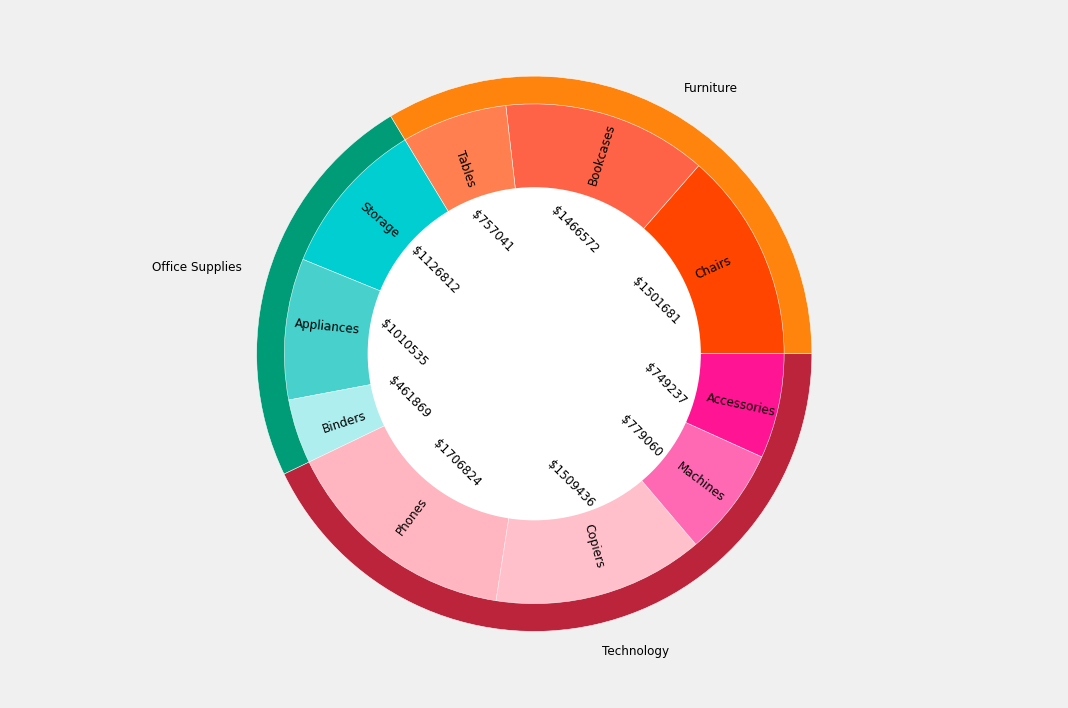

In [173]:
plt.rcParams["figure.figsize"] = (15,10) # width and height of figure is defined in inches
fig, ax = plt.subplots()
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
width = 0.1
outer_colors = ['#FE840E','#009B77','#BC243C'] # Outer colors of the pie chart
inner_colors = ['Orangered','tomato','coral',"darkturquoise","mediumturquoise","paleturquoise","lightpink","pink","hotpink","deeppink"] # inner colors of the pie chart
pie = ax.pie(Top_subcat_1['Sales'], radius=1, labels=Top_subcat_1['CategoryS'],colors=outer_colors,wedgeprops=dict(edgecolor='w'))
pie2 = ax.pie(Top_subcat['Sales'], radius=1-width, labels=Top_subcat['Sub-CategoryS'],autopct= autopct_format(Top_subcat['Sales']),labeldistance=0.7,colors=inner_colors,wedgeprops=dict(edgecolor='w'), pctdistance=0.53,rotatelabels =True)
# Rotate fractions
# [0] = wedges, [1] = labels, [2] = fractions
fraction_text_list = pie2[2]
for text in fraction_text_list: 
    text.set_rotation(315) # rotate the autopct values
centre_circle = plt.Circle((0,0),0.6,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

We can see that Sub-Category - Phones generated the highest revenue of about $1706824!



# forecasting furniture sales

In [174]:
furniture = order.loc[order['CategoryS']=='Furniture']

In [175]:
furniture['OrderDateS'].min(),furniture['OrderDateS'].max()

('2012-01-01', '2015-12-31')

# Data Processing

In [176]:
furniture.columns


Index(['RowIDS', 'ORDERIDS', 'OrderDateS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS', 'Sales'],
      dtype='object')

In [177]:
r_col = ['RowIDS', 'ORDERIDS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS']


In [178]:
furniture.drop(r_col, axis =1 , inplace=True)


In [179]:
furniture

,OrderDateS,Sales
1,2014-05-23,174.2860
7,2015-02-11,688.7400
9,2015-06-12,377.6000
10,2012-08-29,500.5760
14,2012-05-01,246.4800
...,...,...
51281,2015-07-02,734.4000
51283,2013-12-11,769.1760
51285,2014-06-13,460.1688
51286,2012-06-06,506.4300


In [180]:
furniture.rename(columns={'OrderDateS':'Order Date'},inplace= True)
furniture['Order Date']=pd.to_datetime(furniture['Order Date'])
furniture = furniture.sort_values('Order Date')
furniture

,Order Date,Sales
16685,2012-01-01,113.6700
51267,2012-01-03,666.8400
5067,2012-01-03,211.1805
7823,2012-01-03,159.4440
31546,2012-01-03,68.8680
...,...,...
50953,2015-12-31,1048.7313
35479,2015-12-31,323.1360
3756,2015-12-31,173.7600
40734,2015-12-31,364.5900


In [181]:
furniture  = furniture.set_index('Order Date') #for making the order date as the index col


In [182]:
furniture


,Sales
Order Date,
2012-01-01,113.6700
2012-01-03,666.8400
2012-01-03,211.1805
2012-01-03,159.4440
2012-01-03,68.8680
...,...
2015-12-31,1048.7313
2015-12-31,323.1360
2015-12-31,173.7600


In [183]:
furniture_y= furniture['Sales'].resample('MS').mean() 
#resample -Grouping 
# MS -> Month Start frequency



In [184]:
furniture_y #

Order Date
2012-01-01    430.796912
2012-02-01    441.967747
2012-03-01    437.796465
2012-04-01    303.856882
2012-05-01    414.738933
2012-06-01    416.220937
2012-07-01    352.617558
2012-08-01    438.712282
2012-09-01    449.443463
2012-10-01    465.260448
2012-11-01    451.207300
2012-12-01    452.769859
2013-01-01    407.250436
2013-02-01    488.771343
2013-03-01    466.799413
2013-04-01    452.081588
2013-05-01    437.076584
2013-06-01    391.734337
2013-07-01    307.343637
2013-08-01    436.311562
2013-09-01    427.402583
2013-10-01    468.640463
2013-11-01    384.278241
2013-12-01    438.084794
2014-01-01    572.060145
2014-02-01    454.753418
2014-03-01    408.270580
2014-04-01    384.415368
2014-05-01    379.443107
2014-06-01    402.973921
2014-07-01    396.982868
2014-08-01    462.123263
2014-09-01    374.488813
2014-10-01    347.543029
2014-11-01    406.631529
2014-12-01    424.934875
2015-01-01    428.217612
2015-02-01    424.285515
2015-03-01    439.732262
2015-04-01    

# 3. Building the Arima Model and Evaluation  <a class="anchor" id="3"></a>

# Time Series Forecasting with ARIMA

- **ARIMA** stands for **Autoregressive Integrated Moving Average Model**. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.


- So, **ARIMA**, short for **AutoRegressive Integrated Moving Average**, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.


- **ARIMA Models** are specified by three order parameters: (p, d, q), 

   where,

   - p is the order of the AR term

   - q is the order of the MA term

   - d is the number of differencing required to make the time series stationary


- **AR(p) Autoregression** – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.


- **I(d) Integration** – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.


- **MA(q) Moving Average** – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


## **Types of ARIMA Model**


- **ARIMA** : Non-seasonal Autoregressive Integrated Moving Averages
- **SARIMA** : Seasonal ARIMA
- **SARIMAX** : Seasonal ARIMA with exogenous variables



If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for **Seasonal ARIMA**.

- An ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR and the MA terms. So the equation of an ARIMA model becomes :


![ARIMA Model](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min-865x77.png?ezimgfmt=ng:webp/ngcb1)





### **ARIMA model in words**:


Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

In [187]:
#ARIMA --> Auto-regressive Integrated Moving Average 
#ARIMA(p,d,q)# ARIMA
#the three parameters denotes Seasonality , Trend and Noise in Our Data

In [185]:
type(furniture_y)

pandas.core.series.Series

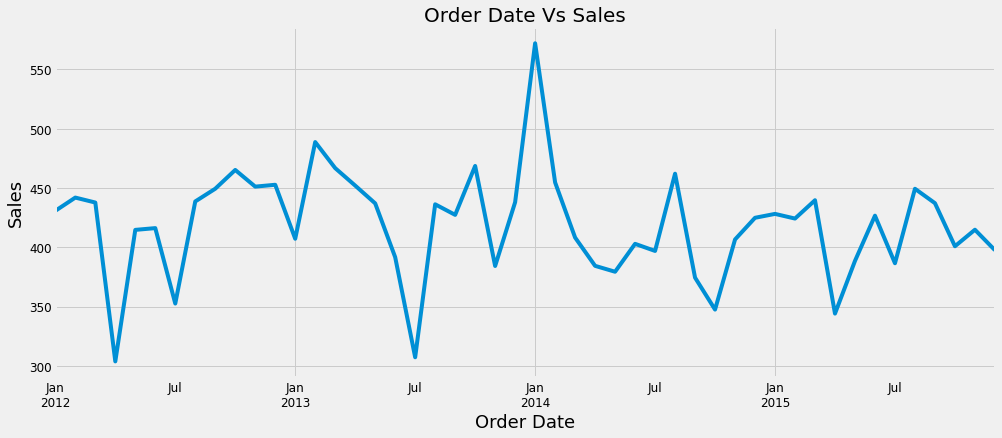

In [186]:
furniture_y.plot(figsize=(15,6))
plt.ylabel("Sales",fontsize=18)
plt.xlabel("Order Date",fontsize=18)
plt.title("Order Date Vs Sales",fontsize=20)
plt.show()

Time Series seasonality pattern

In [64]:
from pylab import rcParams as rc

In [65]:
rc['figure.figsize']= 10, 14


In [66]:
decomposition = sm.tsa.seasonal_decompose(furniture_y,model='additive') #

# y(t) = Level + Trend + Seasonality + Noise --> Additive

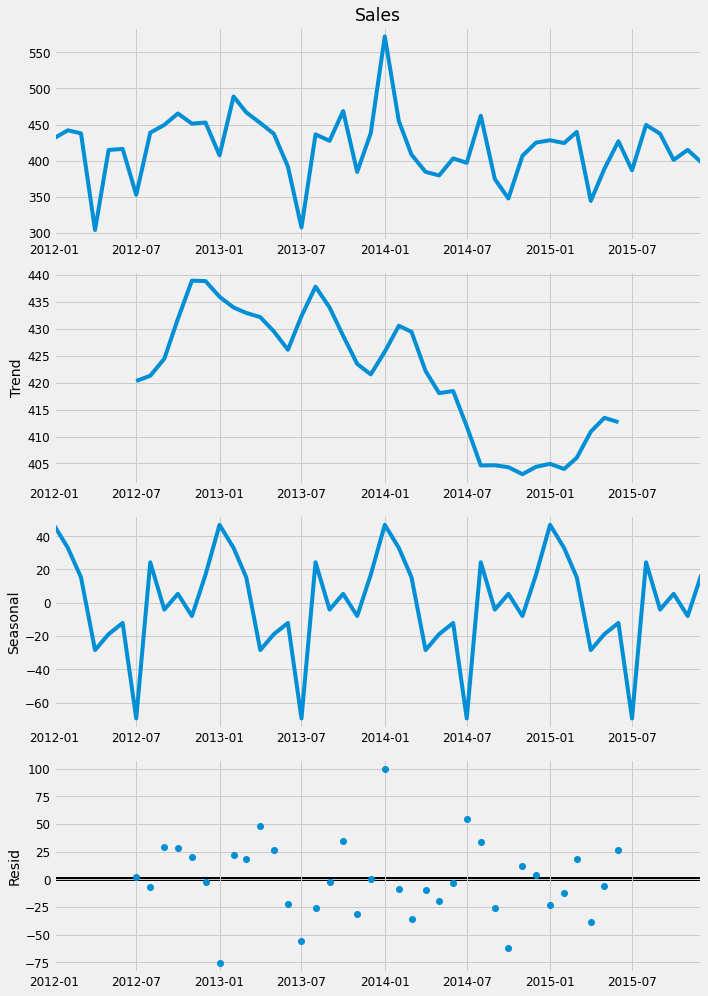

In [67]:
fig = decomposition.plot() #

In [188]:
#
p=d=q=range(0,2)


In [189]:
for i in p:
    print(i)

0
1


In [190]:
for i in itertools.product(p,d,q):
    print (i) 

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


In [191]:
pdq = list(itertools.product(p,d,q))

In [192]:
seasonal_pdq = [(x[0],x[1],x[2], 12) for x in pdq]
seasonal_pdq 

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [193]:
print ("Examples of parameter combinations for Seasonal ARIMA.")
print ('SARIMAX: {} x {}'.format (pdq[1], seasonal_pdq[1]))
print ('SARINAX: {} x {}'.format (pdq[1], seasonal_pdq[2]))
print ("SARINAX: {} x {}".format (pdq[2], seasonal_pdq[3]))
print ("SARINAX: {} x {}".format (pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA.
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARINAX: (0, 0, 1) x (0, 1, 0, 12)
SARINAX: (0, 1, 0) x (0, 1, 1, 12)
SARINAX: (0, 1, 0) x (1, 0, 0, 12)


In [75]:
#AIC : Akaike Information Criteria
#It is a measure of a statistical model
#Measure of goodness of fit
#Lower AIC is better
for param in pdq:  
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_y,order = param, seasonal_order = param_seasonal ,
                                            enforce_stationarity= False , enforce_invertibility= False )
            results = mod.fit()
            
            print('ARIMA{} x {} 12 -- AIC : {}'.format(param, param_seasonal, results.aic))
            
        except:
             continue

ARIMA(0, 0, 0) x (0, 0, 0, 12) 12 -- AIC : 703.450692067462
ARIMA(0, 0, 0) x (0, 0, 1, 12) 12 -- AIC : 1171.560187716672
ARIMA(0, 0, 0) x (0, 1, 0, 12) 12 -- AIC : 389.74562162237083
ARIMA(0, 0, 0) x (0, 1, 1, 12) 12 -- AIC : 239.9062514518913
ARIMA(0, 0, 0) x (1, 0, 0, 12) 12 -- AIC : 401.3270855016417
ARIMA(0, 0, 0) x (1, 0, 1, 12) 12 -- AIC : 1336.9809533037683
ARIMA(0, 0, 0) x (1, 1, 0, 12) 12 -- AIC : 262.95544672421784
ARIMA(0, 0, 0) x (1, 1, 1, 12) 12 -- AIC : 241.43259983025902
ARIMA(0, 0, 1) x (0, 0, 0, 12) 12 -- AIC : 637.3687590918582
ARIMA(0, 0, 1) x (0, 0, 1, 12) 12 -- AIC : 2649.5720440906616
ARIMA(0, 0, 1) x (0, 1, 0, 12) 12 -- AIC : 378.89358001187867
ARIMA(0, 0, 1) x (0, 1, 1, 12) 12 -- AIC : 228.02995542791692
ARIMA(0, 0, 1) x (1, 0, 0, 12) 12 -- AIC : 403.73973163882084
ARIMA(0, 0, 1) x (1, 0, 1, 12) 12 -- AIC : 2561.98713495813
ARIMA(0, 0, 1) x (1, 1, 0, 12) 12 -- AIC : 262.7109597500714
ARIMA(0, 0, 1) x (1, 1, 1, 12) 12 -- AIC : 229.87020926018855
ARIMA(0, 1, 0) x 

the above suggests that ARIMA(1, 1, 1) x (1, 1, 1, 12) 12 yields the lowes  AIC : 224.68776930456957 . therfore we should consider this to be optimal option . 


# Fitting the ARIMA MODEL

In [76]:
mod = sm.tsa.statespace.SARIMAX(furniture_y,
                               order=(1,1,1),
                               seasonal_order= (1,1,1,12),
                               enforce_invertibility=False)

In [77]:
results = mod.fit()


In [78]:
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2146      0.220      0.976      0.329      -0.216       0.645
ma.L1         -1.0000   1367.668     -0.001      0.999   -2681.580    2679.580
ar.S.L12      -0.0413      0.323     -0.128      0.898      -0.674       0.591
ma.S.L12      -1.0000   1367.780     -0.001      0.999   -2681.800    2679.800
sigma2      1558.5470      0.845   1844.477      0.000    1556.891    1560.203


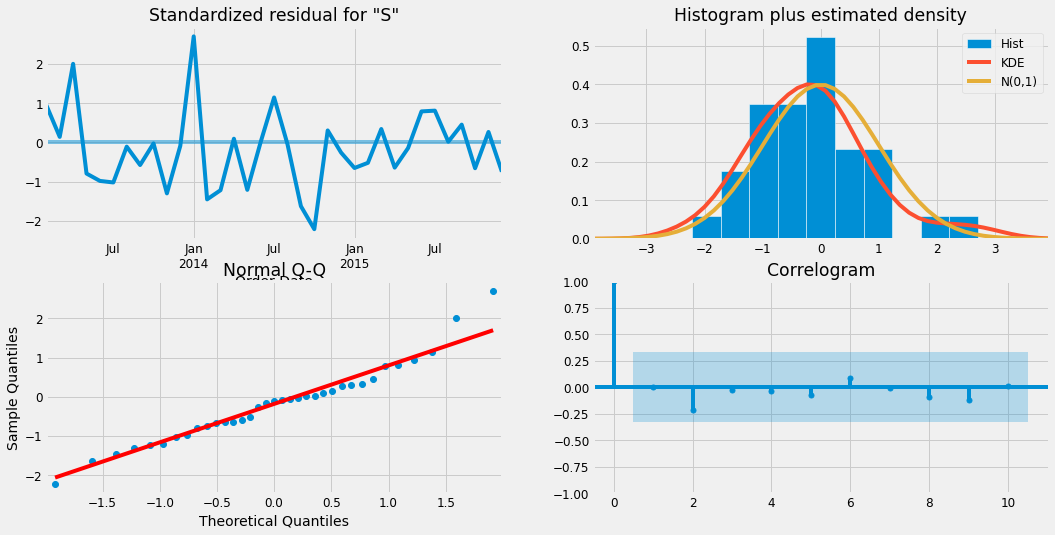

In [79]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

it is not pefect , however , our model diagnostics suggests that residuals are near normally distributed

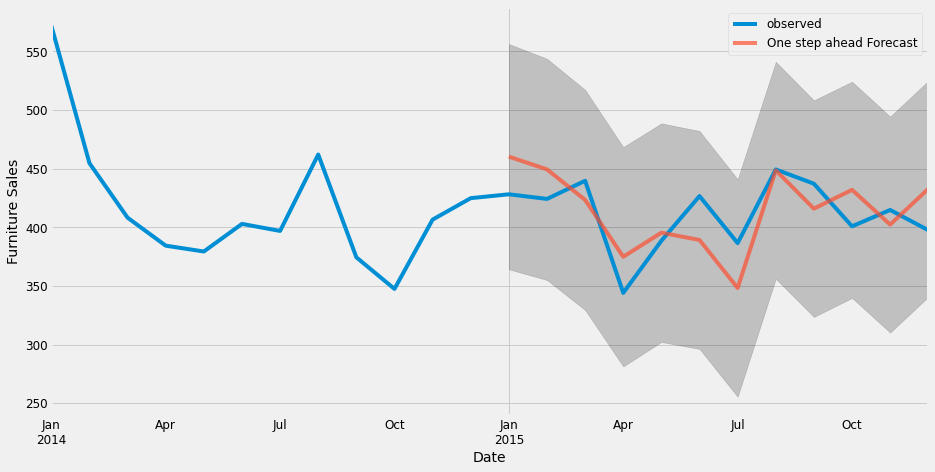

In [80]:
pred = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = furniture_y['2014':].plot(label= 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One step ahead Forecast',
                        alpha = 0.7, figsize= (14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color = 'k', alpha= 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [81]:
furniture_forecasted = pred.predicted_mean
furn_truth = furniture_y['2015-01-01':]
mse = ((furniture_forecasted - furn_truth) ** 2).mean()

print('MSE of forecast :{}'.format(round(mse,2)))


MSE of forecast :717.63


The   Mean Squared Error of our forecast is  717.63
In statistics, the mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors ,that is the average squared differnce between the estimated values and what is estimated . The MSE is a measure of the quality of an estimator 
#the smaller the MSE , the closer we are finding the line of best fit.

# Producing and visualizing forecasts 

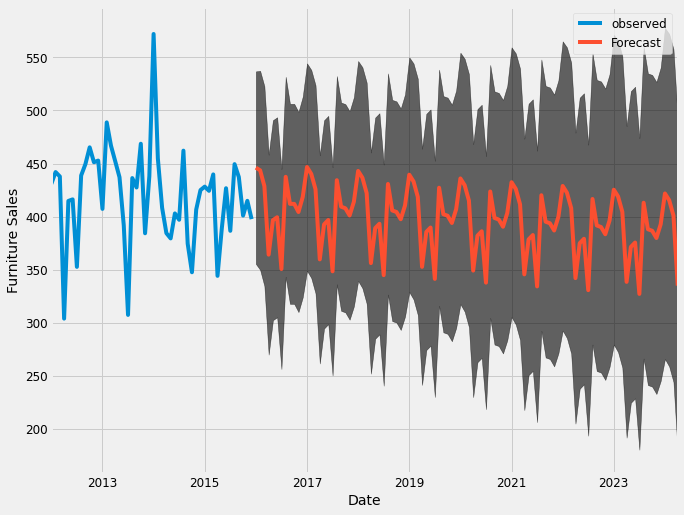

In [82]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = furniture_y.plot(label='observed', figsize=(10,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

# Office Supplies Forecast

In [83]:
os = order.loc[order['CategoryS']=='Office Supplies']

In [84]:
os['OrderDateS'].min(),os['OrderDateS'].max()

('2012-01-01', '2015-12-31')

# Data Processing

In [85]:
os.columns

Index(['RowIDS', 'ORDERIDS', 'OrderDateS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS', 'Sales'],
      dtype='object')

In [86]:
r_col = ['RowIDS', 'ORDERIDS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS']

In [87]:
os.drop(r_col, axis =1 , inplace=True)

In [88]:
os

,OrderDateS,Sales
2,2015-04-25,72.784
4,2014-04-24,71.970
6,2014-12-07,831.240
8,2013-11-26,17.460
11,2015-08-13,890.595
...,...,...
51248,2014-05-23,662.840
51261,2013-09-10,492.300
51271,2013-11-26,107.940
51277,2014-02-27,756.000


In [89]:
os.rename(columns={'OrderDateS':'Order Date'},inplace= True)
os['Order Date']=pd.to_datetime(os['Order Date'])
os = os.sort_values('Order Date')
os.rename(columns={'OrderDateS':'Order Date'},inplace= True)
os['Order Date']=pd.to_datetime(os['Order Date'])
os = os.sort_values('Order Date')
os

,Order Date,Sales
8220,2012-01-01,120.366
48539,2012-01-01,55.242
2827,2012-01-01,408.300
31543,2012-01-01,66.120
16398,2012-01-01,44.865
...,...,...
12230,2015-12-31,27.840
29454,2015-12-31,30.270
20866,2015-12-31,58.740
27155,2015-12-31,557.280


In [90]:
os = os.set_index('Order Date') #for making the order date as the index col


In [91]:
os

,Sales
Order Date,
2012-01-01,120.366
2012-01-01,55.242
2012-01-01,408.300
2012-01-01,66.120
2012-01-01,44.865
...,...
2015-12-31,27.840
2015-12-31,30.270
2015-12-31,58.740


In [92]:
os_y= os['Sales'].resample('MS').mean() 
#resample -Grouping 
# MS -> Month Start frequency

In [93]:
os_y

Order Date
2012-01-01    117.226320
2012-02-01    104.540117
2012-03-01     99.932154
2012-04-01    134.800790
2012-05-01    143.318362
2012-06-01    118.604185
2012-07-01    134.189809
2012-08-01    107.531826
2012-09-01    151.955702
2012-10-01    109.646410
2012-11-01    131.462699
2012-12-01    118.937683
2013-01-01    144.982129
2013-02-01     97.189417
2013-03-01    132.318426
2013-04-01    113.108401
2013-05-01    114.565361
2013-06-01    106.975777
2013-07-01    113.316408
2013-08-01    145.598462
2013-09-01    104.429364
2013-10-01    100.991719
2013-11-01    113.917531
2013-12-01    134.055308
2014-01-01    147.690144
2014-02-01    140.854858
2014-03-01    136.581219
2014-04-01    114.980842
2014-05-01    112.924568
2014-06-01    120.398067
2014-07-01    128.034728
2014-08-01    100.161042
2014-09-01    107.223304
2014-10-01    123.433527
2014-11-01    113.808610
2014-12-01    134.659168
2015-01-01    135.911196
2015-02-01    121.819033
2015-03-01    116.306249
2015-04-01    

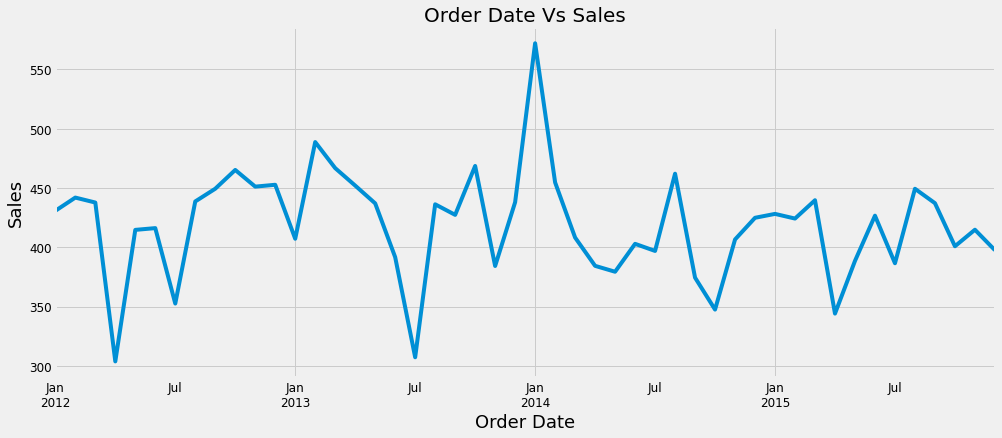

In [94]:
furniture_y.plot(figsize=(15,6))
plt.ylabel("Sales",fontsize=18)
plt.xlabel("Order Date",fontsize=18)
plt.title("Order Date Vs Sales",fontsize=20)
plt.show()

Time Series seasonality pattern

In [95]:
from pylab import rcParams as rc

In [96]:
rc['figure.figsize']= 10, 14


In [97]:
decomposition = sm.tsa.seasonal_decompose(furniture_y,model='additive') #

# y(t) = Level + Trend + Seasonality + Noise --> Additive

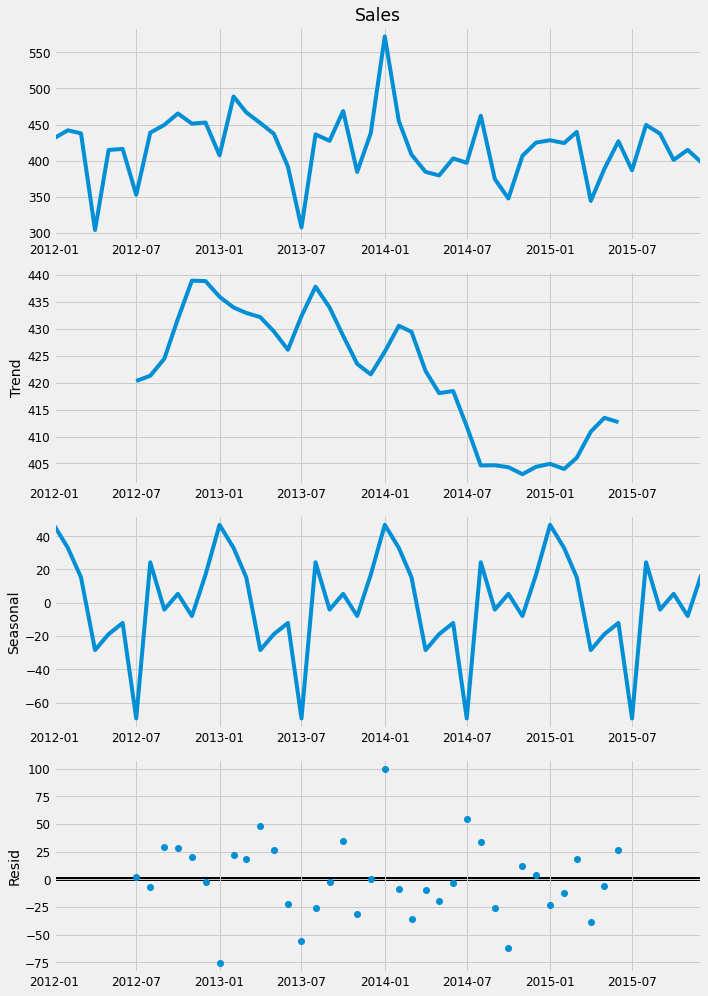

In [98]:
fig = decomposition.plot() #

# Time Series Forecasting with ARIMA

In [99]:
#ARIMA --> Auto-regressive Integrated Moving Average 
#ARIMA(p,d,q)# ARIMA
#the three parameters denotes Seasonality , Trend and Noise in Our Data

In [100]:
#
p=d=q=range(0,2)

In [101]:
for i in p:
    print(i)

0
1


In [102]:
for i in itertools.product(p,d,q):
    print (i) 

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


In [103]:
pdq = list(itertools.product(p,d,q))

In [104]:
seasonal_pdq = [(x[0],x[1],x[2], 12) for x in pdq]
seasonal_pdq 

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [105]:
print ("Examples of parameter combinations for Seasonal ARIMA.")
print ('SARIMAX: {} x {}'.format (pdq[1], seasonal_pdq[1]))
print ('SARINAX: {} x {}'.format (pdq[1], seasonal_pdq[2]))
print ("SARINAX: {} x {}".format (pdq[2], seasonal_pdq[3]))
print ("SARINAX: {} x {}".format (pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA.
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARINAX: (0, 0, 1) x (0, 1, 0, 12)
SARINAX: (0, 1, 0) x (0, 1, 1, 12)
SARINAX: (0, 1, 0) x (1, 0, 0, 12)


In [106]:
#AIC : Akaike Information Criteria
#It is a measure of a statistical model
#Measure of goodness of fit
#Lower AIC is better
for param in pdq:  
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_y,order = param, seasonal_order = param_seasonal ,
                                            enforce_stationarity= False , enforce_invertibility= False )
            results = mod.fit()
            
            print('ARIMA{} x {} 12 -- AIC : {}'.format(param, param_seasonal, results.aic))
            
        except:
             continue

ARIMA(0, 0, 0) x (0, 0, 0, 12) 12 -- AIC : 703.450692067462
ARIMA(0, 0, 0) x (0, 0, 1, 12) 12 -- AIC : 1171.560187716672
ARIMA(0, 0, 0) x (0, 1, 0, 12) 12 -- AIC : 389.74562162237083
ARIMA(0, 0, 0) x (0, 1, 1, 12) 12 -- AIC : 239.9062514518913
ARIMA(0, 0, 0) x (1, 0, 0, 12) 12 -- AIC : 401.3270855016417
ARIMA(0, 0, 0) x (1, 0, 1, 12) 12 -- AIC : 1336.9809533037683
ARIMA(0, 0, 0) x (1, 1, 0, 12) 12 -- AIC : 262.95544672421784
ARIMA(0, 0, 0) x (1, 1, 1, 12) 12 -- AIC : 241.43259983025902
ARIMA(0, 0, 1) x (0, 0, 0, 12) 12 -- AIC : 637.3687590918582
ARIMA(0, 0, 1) x (0, 0, 1, 12) 12 -- AIC : 2649.5720440906616
ARIMA(0, 0, 1) x (0, 1, 0, 12) 12 -- AIC : 378.89358001187867
ARIMA(0, 0, 1) x (0, 1, 1, 12) 12 -- AIC : 228.02995542791692
ARIMA(0, 0, 1) x (1, 0, 0, 12) 12 -- AIC : 403.73973163882084
ARIMA(0, 0, 1) x (1, 0, 1, 12) 12 -- AIC : 2561.98713495813
ARIMA(0, 0, 1) x (1, 1, 0, 12) 12 -- AIC : 262.7109597500714
ARIMA(0, 0, 1) x (1, 1, 1, 12) 12 -- AIC : 229.87020926018855
ARIMA(0, 1, 0) x 

the above suggests that ARIMA(1, 1, 1) x (1, 1, 1, 12) 12 yields the lowes  AIC : 224.68776930456957 . therfore we should consider this to be optimal option . 


In [107]:
# Fitting the ARIMA MODEL

In [108]:
mod = sm.tsa.statespace.SARIMAX(furniture_y,
                               order=(1,1,1),
                               seasonal_order= (1,1,1,12),
                               enforce_invertibility=False)

In [109]:
results = mod.fit()


In [110]:
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2146      0.220      0.976      0.329      -0.216       0.645
ma.L1         -1.0000   1367.668     -0.001      0.999   -2681.580    2679.580
ar.S.L12      -0.0413      0.323     -0.128      0.898      -0.674       0.591
ma.S.L12      -1.0000   1367.780     -0.001      0.999   -2681.800    2679.800
sigma2      1558.5470      0.845   1844.477      0.000    1556.891    1560.203


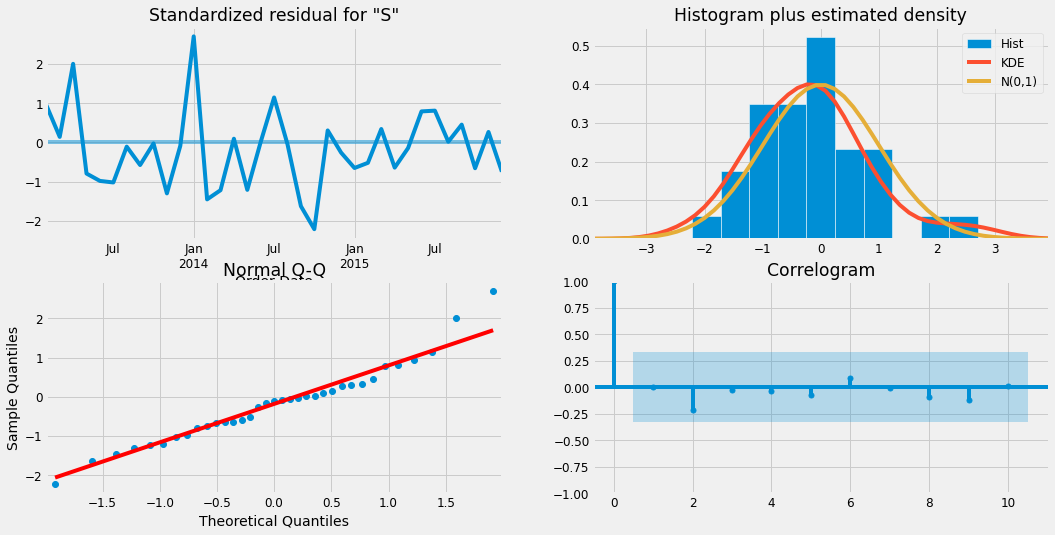

In [111]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

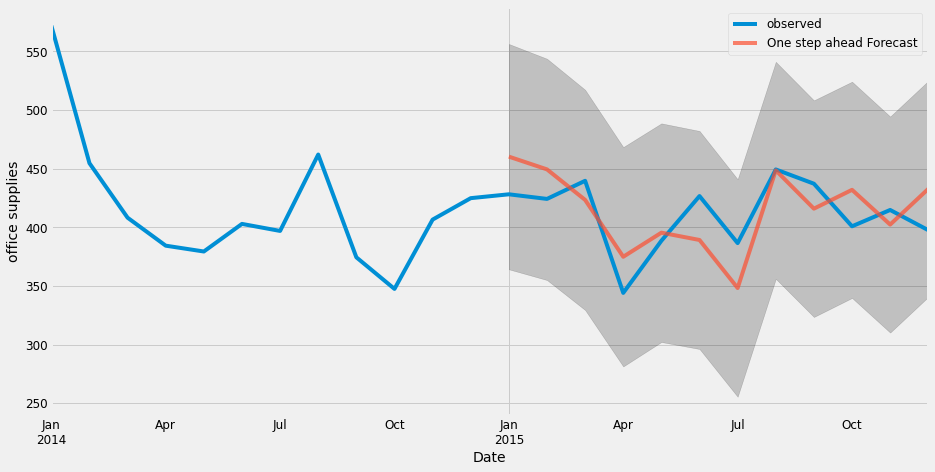

In [112]:
pred = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = furniture_y['2014':].plot(label= 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One step ahead Forecast',
                        alpha = 0.7, figsize= (14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color = 'k', alpha= 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('office supplies')
plt.legend()

plt.show()

In [113]:
furniture_forecasted = pred.predicted_mean
furn_truth = furniture_y['2014-04-01':]
mse = ((furniture_forecasted - furn_truth) ** 2).mean()

print('MSE of forecast :{}'.format(round(mse,2)))


MSE of forecast :717.63


The   Mean Squared Error of our forecast is  717.63
In statistics, the mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors ,that is the average squared differnce between the estimated values and what is estimated . The MSE is a measure of the quality of an estimator 
#the smaller the MSE , the closer we are finding the line of best fit.

# Producing and visualizing forecasts 

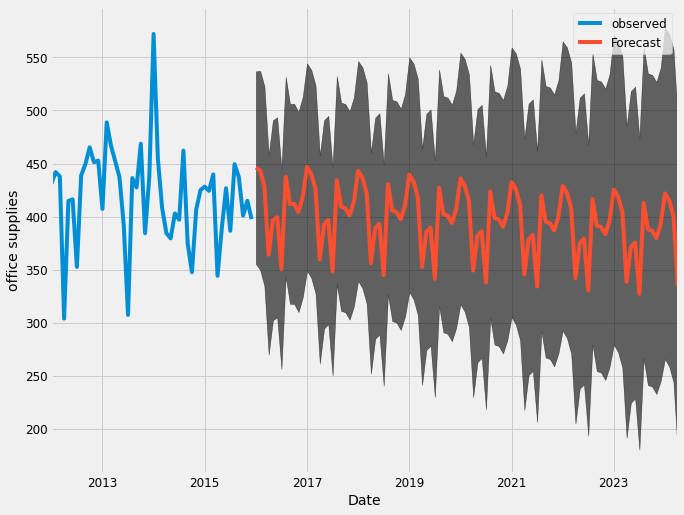

In [114]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = furniture_y.plot(label='observed', figsize=(10,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('office supplies')

plt.legend()
plt.show()

# Technolagy Forecast

In [115]:
Technology= order.loc[order['CategoryS']=='Technology']

In [116]:
Technology['OrderDateS'].min(),Technology['OrderDateS'].max()

('2012-01-02', '2015-12-31')

In [117]:
Technology.columns


Index(['RowIDS', 'ORDERIDS', 'OrderDateS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS', 'Sales'],
      dtype='object')

In [118]:
r_col = ['RowIDS', 'ORDERIDS', 'ShipDateS', 'ShipModeS',
       'Customer_IDS', 'CustomerNameS', 'SegmentS', 'CityS', 'StateS',
       'CountryS', 'RegionS', 'MarketS', 'ProductIDS', 'CategoryS',
       'Sub-CategoryS', 'Product NameS', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'OrderPriority', 'PostalCodeS']


In [119]:
Technology.drop(r_col, axis =1 , inplace=True)


In [120]:
Technology

,OrderDateS,Sales
0,2012-10-14,958.680
3,2015-01-29,415.080
5,2014-05-07,26.176
13,2015-11-11,664.767
15,2015-10-30,1269.840
...,...,...
51279,2013-04-09,367.830
51282,2015-07-07,1164.375
51284,2015-11-21,517.920
51288,2014-03-23,247.455


In [121]:
Technology.rename(columns={'OrderDateS':'Order Date'},inplace= True)
Technology['Order Date']=pd.to_datetime(Technology['Order Date'])
Technology = Technology.sort_values('Order Date')
Technology.rename(columns={'OrderDateS':'Order Date'},inplace= True)
Technology['Order Date']=pd.to_datetime(Technology['Order Date'])
Technology = Technology.sort_values('Order Date')
Technology

,Order Date,Sales
38778,2012-01-02,314.220
31121,2012-01-03,195.200
49609,2012-01-03,192.870
45973,2012-01-03,912.456
31265,2012-01-03,69.300
...,...,...
36099,2015-12-31,530.220
37826,2015-12-31,865.620
50445,2015-12-31,74.800
33632,2015-12-31,171.990


In [122]:
Technology = Technology.set_index('Order Date') #for making the order date as the index col
Technology

,Sales
Order Date,
2012-01-02,314.220
2012-01-03,195.200
2012-01-03,192.870
2012-01-03,912.456
2012-01-03,69.300
...,...
2015-12-31,530.220
2015-12-31,865.620
2015-12-31,74.800


In [123]:
os_y= os['Sales'].resample('MS').mean() 
#resample -Grouping 
# MS -> Month Start frequency

In [124]:
os_y

Order Date
2012-01-01    117.226320
2012-02-01    104.540117
2012-03-01     99.932154
2012-04-01    134.800790
2012-05-01    143.318362
2012-06-01    118.604185
2012-07-01    134.189809
2012-08-01    107.531826
2012-09-01    151.955702
2012-10-01    109.646410
2012-11-01    131.462699
2012-12-01    118.937683
2013-01-01    144.982129
2013-02-01     97.189417
2013-03-01    132.318426
2013-04-01    113.108401
2013-05-01    114.565361
2013-06-01    106.975777
2013-07-01    113.316408
2013-08-01    145.598462
2013-09-01    104.429364
2013-10-01    100.991719
2013-11-01    113.917531
2013-12-01    134.055308
2014-01-01    147.690144
2014-02-01    140.854858
2014-03-01    136.581219
2014-04-01    114.980842
2014-05-01    112.924568
2014-06-01    120.398067
2014-07-01    128.034728
2014-08-01    100.161042
2014-09-01    107.223304
2014-10-01    123.433527
2014-11-01    113.808610
2014-12-01    134.659168
2015-01-01    135.911196
2015-02-01    121.819033
2015-03-01    116.306249
2015-04-01    

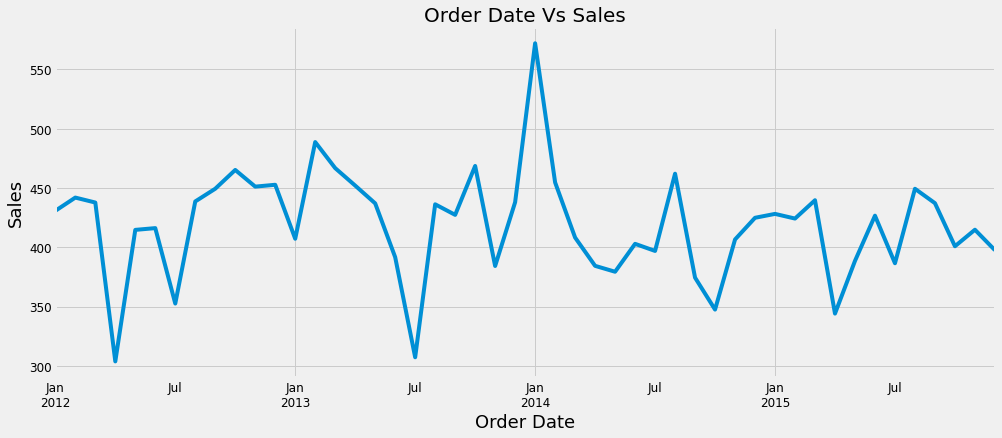

In [125]:
furniture_y.plot(figsize=(15,6))
plt.ylabel("Sales",fontsize=18)
plt.xlabel("Order Date",fontsize=18)
plt.title("Order Date Vs Sales",fontsize=20)
plt.show()

In [126]:
from pylab import rcParams as rc

In [127]:
rc['figure.figsize']= 10, 14


In [128]:
decomposition = sm.tsa.seasonal_decompose(furniture_y,model='additive') #

# y(t) = Level + Trend + Seasonality + Noise --> Additive

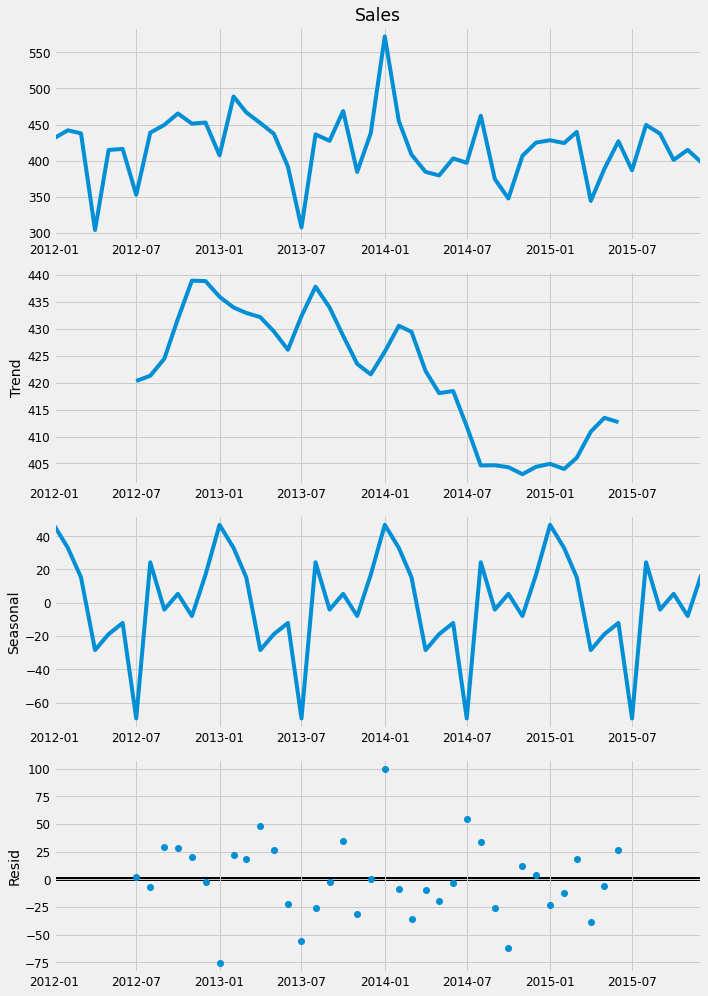

In [129]:
fig = decomposition.plot() #

# Time Series Forecasting with ARIMA


In [130]:
#ARIMA --> Auto-regressive Integrated Moving Average 
#ARIMA(p,d,q)# ARIMA
#the three parameters denotes Seasonality , Trend and Noise in Our Data

In [131]:
mod = sm.tsa.statespace.SARIMAX(furniture_y,
                               order=(1,1,1),
                               seasonal_order= (1,1,1,12),
                               enforce_invertibility=False)

In [132]:
results = mod.fit()


In [133]:
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2146      0.220      0.976      0.329      -0.216       0.645
ma.L1         -1.0000   1367.668     -0.001      0.999   -2681.580    2679.580
ar.S.L12      -0.0413      0.323     -0.128      0.898      -0.674       0.591
ma.S.L12      -1.0000   1367.780     -0.001      0.999   -2681.800    2679.800
sigma2      1558.5470      0.845   1844.477      0.000    1556.891    1560.203


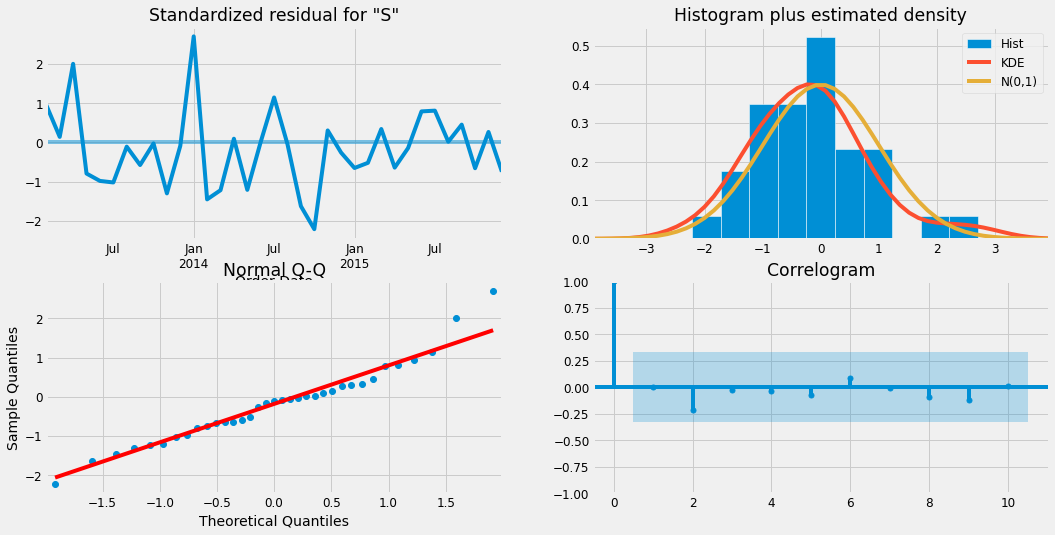

In [134]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

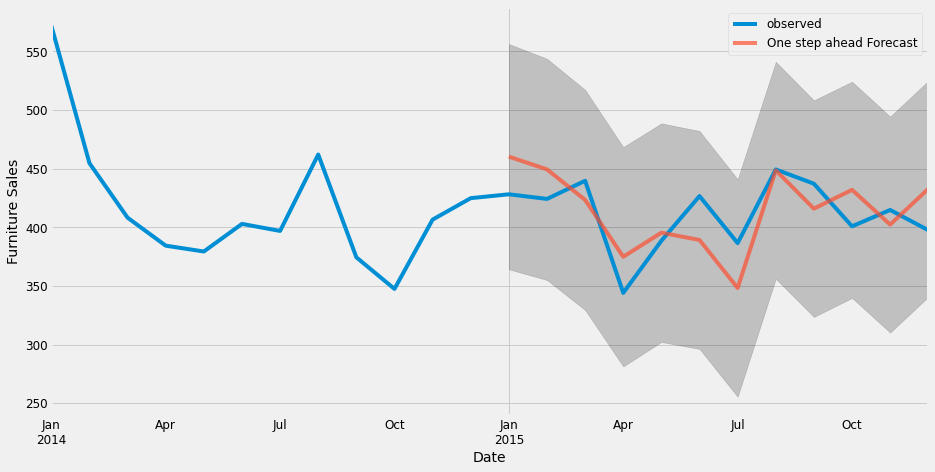

In [135]:
pred = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = furniture_y['2014':].plot(label= 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One step ahead Forecast',
                        alpha = 0.7, figsize= (14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color = 'k', alpha= 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [136]:
furniture_forecasted = pred.predicted_mean
furn_truth = furniture_y['2014-04-01':]
mse = ((furniture_forecasted - furn_truth) ** 2).mean()

print('MSE of forecast :{}'.format(round(mse,2)))


MSE of forecast :717.63


The   Mean Squared Error of our forecast is  717.63
In statistics, the mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors ,that is the average squared differnce between the estimated values and what is estimated . The MSE is a measure of the quality of an estimator 
#the smaller the MSE , the closer we are finding the line of best fit.

# Producing and visualizing forecasts 

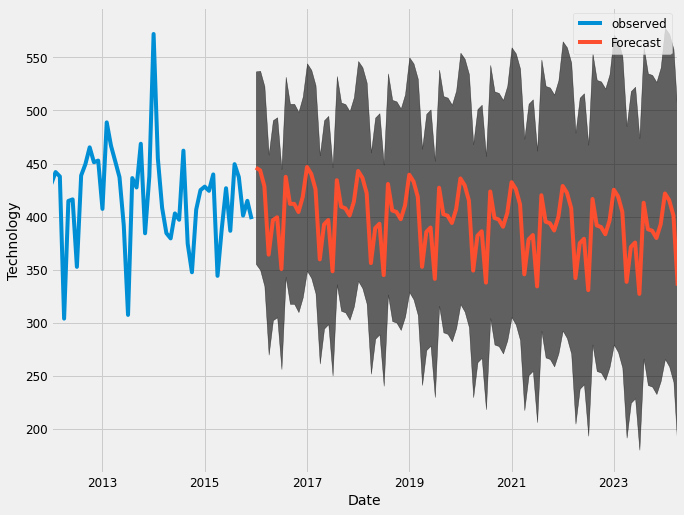

In [137]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = furniture_y.plot(label='observed', figsize=(10,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Technology')

plt.legend()
plt.show()